In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import multivariate_normal
from scipy.stats import tmean, tstd
from scipy.stats import norm
import scipy.stats    as st
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML

from pyDOE import *
import gpflow as gp
from scipy.spatial import distance_matrix

# plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

In [2]:
import sys
sys.path.append('/Users/agarbuno/postdoc/python/modules/ipuq/')

In [4]:
%load_ext autoreload
%autoreload 2
from ces.models import *
from ces.bivariate_plots  import *

from ces.calibrate import *
import ces.emulate as emu
from ces.sample import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
save_figs = False

<a id='contents'></a> 
# Table of contents

1. **[Calibrate](#calibrate)**  
2. **[Emulate](#emulate)**  
    **2.1. [Linear prior](#linear-emulate-all)**  
    **2.2. [Mixed prior](#mixed-emulate-all)**  
    **2.3. [Time variability](#time-var)**  
    **2.4. [Parameter variability](#par-var)**
3. **[Sample](#sample)**


<a id='calibrate'></a> 
#  Calibrate

[go back](#contents)

In [6]:
T     = 360.                                # Final time
dt    = 100.                               # Timesteps in each time unit
steps = int(T * dt)                        # Overall number of steps
t     = np.linspace(0, T, steps + 1)       # time array

T_roll   = 10.
T_spinup = 30.

w0 = (1., 1., 1.)                          # Initial conditions

In [8]:
model          = Lorenz63Log()
model.l_window = T_roll
model.freq     = dt

ws = model.solve(w0, t)
y  = model.statistics(ws)

In [9]:
n_obs = 9                               # number of observations
ustar = np.array([[np.log(28.)], [np.log(8./3)]])      # true parameters
p = 2                                   # parameter dimensionality

# Generate data
np.random.seed(1)
# ws = integrate.odeint(lorenz2d, w0, t, args = (28., 8./3))
xs, ys, zs = ws[:,0], ws[:,1], ws[:,2]
ws = [xs, ys, zs, xs**2, ys**2, zs**2, xs*ys, xs*zs, ys*zs]

# Compute the means of windows of size 10. 
# Allow for a spinup of 30 units of time and gather results
wt = np.asarray([xs[-1], ys[-1], zs[-1]])
gs = [np.asarray(pd.Series(k).rolling(window = int(T_roll * dt)).mean()) for k in ws]
Gamma = np.cov(np.asarray(gs)[:,t>T_spinup])
# y_obs = np.asarray(gs)[:,-1]
y_obs = np.asarray(gs)[:,t>T_spinup].mean(axis = 1)

In [10]:
y_obs

array([3.94147535e-01, 3.91695570e-01, 2.36145907e+01, 6.29755846e+01,
       8.08477294e+01, 6.30906624e+02, 6.29763245e+01, 1.06691603e+01,
       1.02856931e+01])

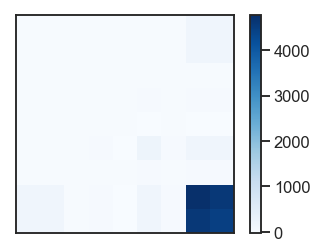

In [11]:
plt.imshow(Gamma, cmap = 'Blues')
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.colorbar();

In [12]:
Jnoise = np.linalg.cholesky(Gamma)
J      = 100

T_eks     = 60
steps_eks = int(T_eks * dt)                     
t_eks     = np.linspace(0, T_eks, steps_eks + 1)

eks = EnsembleKalmanSampler(p = p, n_obs = n_obs, J = J)
eks.ustar    = ustar
eks.T        = 50
eks.mu       = np.array([3.3, 1.2]).reshape(2,-1)
eks.sigma    = np.diag([0.15**2, 0.5**2])

eks.parallel = True
eks.mute_bar = True

np.random.seed(2016)
# np.random.seed(1988)
# U0 = np.random.uniform(1,30, [eks.p, eks.J])
U0 = eks.mu + eks.sigma**0.5 @ np.random.normal(0, 1, [eks.p, eks.J])

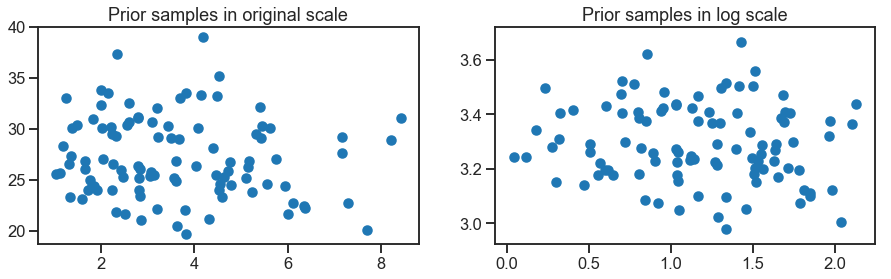

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
axes[0].scatter(np.exp(U0[1]), np.exp(U0[0]))
axes[0].set_title('Prior samples in original scale');
axes[1].scatter(U0[1], U0[0])
axes[1].set_title('Prior samples in log scale');

In [14]:
eks.run(y_obs, U0, model, Gamma, Jnoise, wt = wt, t = t_eks)

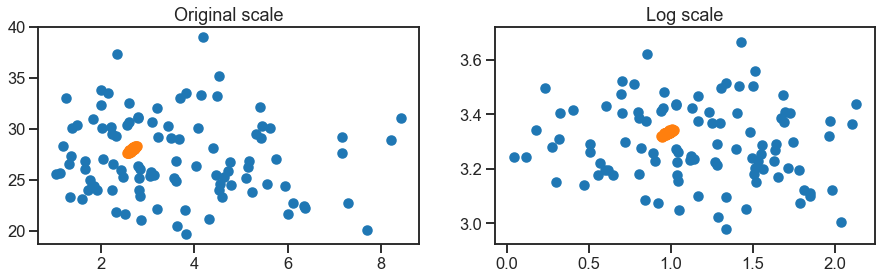

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
axes[0].scatter(np.exp(U0[1]), np.exp(U0[0]))
axes[1].scatter(U0[1], U0[0])

axes[0].scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]))
axes[1].scatter(eks.Ustar[1], eks.Ustar[0])

axes[0].set_title('Original scale');
axes[1].set_title('Log scale');

In [16]:
eks.Ustar.max(axis = 1)

array([3.3449555 , 1.01752418])

In [17]:
# b \in [25, 30]
logr_lo = 2.8
logr_up = 3.8

# b \in [2, 4]
logb_lo = 0.0
logb_up = 3.0

# b \in [25, 30]
logr_lo = 3.31
logr_up = 3.35

# b \in [2, 4]
logb_lo = 0.92
logb_up = 1.05

# # b \in [25, 30]
# logr_lo = np.log(25.)
# logr_up = np.log(30.)

# # b \in [2, 4]
# logb_lo = np.log(2.)
# logb_up = np.log(4.)


grid_size = 60
rs, bs = np.meshgrid(np.linspace(logr_lo, logr_up, grid_size),
                   np.linspace(logb_lo, logb_up, grid_size))

In [18]:
eks.mute_bar = False       # Let us show the progress evaluation meter. 

Gs = eks.ensemble_forward_solve(np.vstack([np.array([rs.flatten(), bs.flatten()]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,grid_size**2,replace=True)]]), 
                   model, t_eks)

In [19]:
rb_ = np.vstack([np.array([rs.flatten(), bs.flatten()])]).T

prior = multivariate_normal(mean = eks.mu.flatten(), cov = eks.sigma)
logprior = prior.logpdf(rb_)
logjac = -rb_.sum(axis = 1)

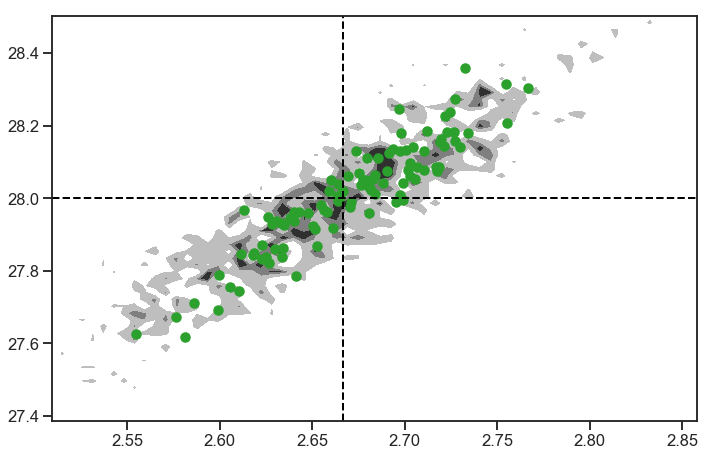

In [20]:
Phi = ((Gs[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)
pltlevels = np.log(find_levels(rs, bs, energy = Phi - logprior - logjac))

fig, ax = plt.subplots(1,1,figsize=(10, 7));
cmap = plt.get_cmap('gray')
plt.contourf(np.exp(bs), np.exp(rs), np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
                      pltlevels, extend = 'min', cmap = cmap_greys)
# plt.colorbar();

plt.scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c')

ax.axvline(x = np.exp(ustar[1]), linestyle = '--', color = 'black', linewidth = 2)    
ax.axhline(y = np.exp(ustar[0]), linestyle = '--', color = 'black', linewidth = 2)

# plt.title('EKS output, last iteration.');
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-phi-noise-alt'
# plt.savefig(paper_directory+file+'.png', dpi=150)

rlims = ax.get_xlim()
blims = ax.get_ylim()

In [21]:
# rs
grid_size = 240

Gs_r = eks.ensemble_forward_solve(np.vstack([np.array([np.linspace(logr_lo, logr_up, grid_size), 
                                           np.log(8./3) * np.ones(grid_size)]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,grid_size,replace=True)]]), 
                   model, t_eks)
# bs
np.linspace(logb_lo, logb_up, grid_size)
Gs_b = eks.ensemble_forward_solve(np.vstack([np.array([np.log(28.) * np.ones(grid_size), 
                                           np.linspace(logb_lo, logb_up, grid_size)]), 
                              np.asarray(ws)[:3][:,np.random.choice(6001,grid_size,replace=True)]]), 
                   model, t_eks)

In [22]:
Phi_r = ((Gs_r[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs_r[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)
Phi_b = ((Gs_b[:n_obs,:] - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs_b[:n_obs,:] - y_obs[:,np.newaxis])).sum(axis = 0)

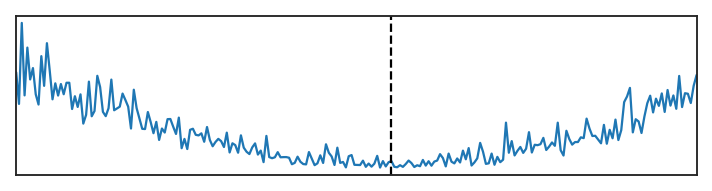

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 3));

plt.plot(np.exp(np.linspace(logr_lo, logr_up, grid_size)), Phi_r)
plt.xlim(blims)
ax.set_xticks([]);
ax.set_yticks([]);
ax.axvline(28.0, linestyle = '--', color = 'black')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-phib-rfixed'
# plt.savefig(paper_directory+file+'.png', dpi=150)

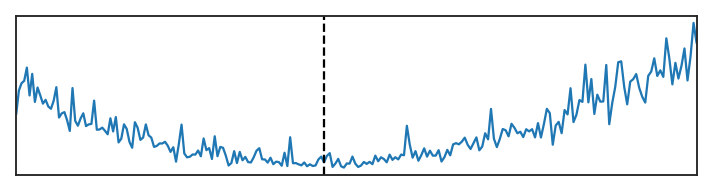

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10, 3));

plt.plot(np.exp(np.linspace(logb_lo, logb_up, grid_size)), Phi_b)
plt.xlim(rlims)
ax.set_xticks([]);
ax.set_yticks([]);
ax.axvline(8./3, linestyle = '--', color = 'black')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-rhib-bfixed'
# plt.savefig(paper_directory+file+'.png', dpi=150)

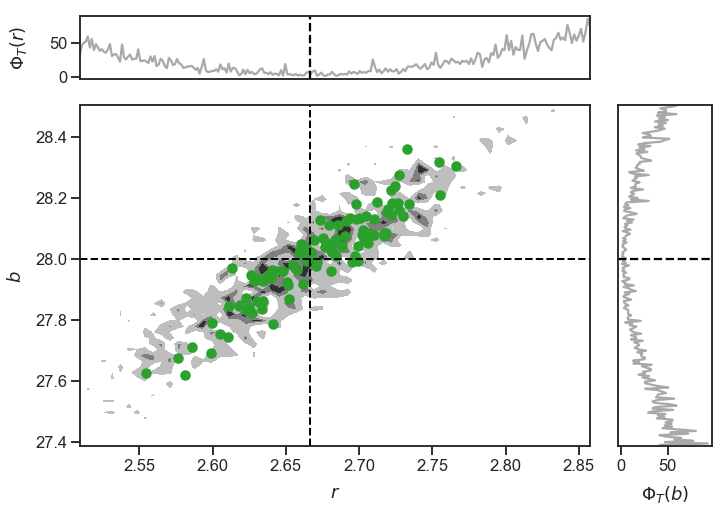

In [25]:
fig = plt.figure(figsize=(10, 7), constrained_layout=True);

gs = fig.add_gridspec(4, 4)
#  -------------------------------------------

f_ax1 = fig.add_subplot(gs[1:, :3])
grid_size = 60
cmap = plt.get_cmap('gray')
f_ax1.contourf(np.exp(bs), np.exp(rs), np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
                      pltlevels, extend = 'min', cmap = cmap_greys)
f_ax1.scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c')
f_ax1.axvline(x = np.exp(ustar[1]), linestyle = '--', color = 'black', linewidth = 2)    
f_ax1.axhline(y = np.exp(ustar[0]), linestyle = '--', color = 'black', linewidth = 2)
f_ax1.set_ylabel(r"$b$", labelpad=10)
f_ax1.set_xlabel(r"$r$", labelpad=10)


#  -------------------------------------------
f_axr = fig.add_subplot(gs[1:, 3])
grid_size = 240
f_axr.plot(Phi_r, np.exp(np.linspace(logr_lo, logr_up, grid_size)), 'darkgray')
f_axr.set_ylim(blims)
# f_axr.set_xticks([]);
f_axr.set_yticks([]);
f_axr.set_xlabel(r"$\Phi_T(b)$", labelpad=10)
f_axr.axhline(28.0, linestyle = '--', color = 'black')

#  -------------------------------------------
f_axb = fig.add_subplot(gs[0, :3])
f_axb.plot(np.exp(np.linspace(logb_lo, logb_up, grid_size)), Phi_b, 'darkgray')
f_axb.set_xlim(rlims)
f_axb.set_xticks([]);
# f_axb.set_yticks([]);
f_axb.set_ylabel(r"$\Phi_T(r)$", labelpad=20)
f_axb.axvline(8./3, linestyle = '--', color = 'black')

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-calibrate-eks'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [26]:
grid_size = 60

<a id='emulate'></a>
# 2. Emulate
[go back](#contents)

In [27]:
def invgamma_roots(theta, locs): 
    gamma_ = st.invgamma(np.exp(theta[0]), scale = np.exp(theta[1]))
    locs_  = locs
    return [      gamma_.cdf(locs_[0]) - .010, 
             1. - gamma_.cdf(locs_[1]) - .010]

In [28]:
lenghtscale_params = []
for thetas in eks.Ustar: 
    dmatrix = distance_matrix(np.exp(thetas).reshape(-1,1), np.exp(thetas).reshape(-1,1))
    ilocs = [1/(dmatrix[dmatrix > 0].max()), 1/(100 * dmatrix[dmatrix > 0].min())]
    soli = opt.root(invgamma_roots, [0, 0], method = 'hybr', args = (ilocs))
    lenghtscale_params.append(np.array([np.exp(soli.x[0]), np.exp(-soli.x[1])]))

In [29]:
lenghtscale_params = np.array(lenghtscale_params).T
lenghtscale_params

array([[1.63327562e+00, 1.57107890e+01],
       [1.24738013e-01, 7.13974550e-04]])

In [30]:
np.array(lenghtscale_params).prod(axis = 0)

array([0.20373156, 0.0112171 ])

In [31]:
list(lenghtscale_params[0])

[1.6332756238130488, 15.71078904407896]

<a id='linear-emulate-all'></a>
## 2.1. Linear mean prior for all components

In [32]:
gp.reset_default_graph_and_session()

In [33]:
def emulate(eks):
    eks.gpmodels = []

    for ii, y in tqdm(enumerate(eks.Gstar[range(eks.n_obs)]), desc = 'GP training: ', total = eks.n_obs):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = eks.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            m  = gp.models.GPR(eks.Ustar.T, y[:,np.newaxis], k, m0)
#             m.kern.lengthscales.prior = gp.priors.Gamma(0.58310201, 0.08164469)
            m.kern.lengthscales.prior = gp.priors.Gamma(list(lenghtscale_params[0]), 
                                                        list(lenghtscale_params[1]))
            m.likelihood.variance = Gamma[ii,ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        eks.gpmodels.append(m)

In [34]:
emulate(eks)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 221.614104
  Number of iterations: 52
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 221.614104
  Number of iterations: 52
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 221.113046
  Number of iterations: 61
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 221.113046
  Number of iterations: 61
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 40.915253
  Number of iterations: 81
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 40.915253
  Number of iterations: 81
  Number of functions evaluations: 111


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 179.025969
  Number of iterations: 74
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 179.025969
  Number of iterations: 74
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 210.108023
  Number of iterations: 87
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 210.108023
  Number of iterations: 87
  Number of functions evaluations: 102


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 392.471931
  Number of iterations: 81
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 392.471931
  Number of iterations: 81
  Number of functions evaluations: 101


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 181.926754
  Number of iterations: 72
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 181.926754
  Number of iterations: 72
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 551.862266
  Number of iterations: 51
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 551.862266
  Number of iterations: 51
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 547.037842
  Number of iterations: 53
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 547.037842
  Number of iterations: 53
  Number of functions evaluations: 59


In [35]:
gpmeans, gpvars = emu.predict_gps(eks, np.vstack([rs.flatten(), bs.flatten()]).T)

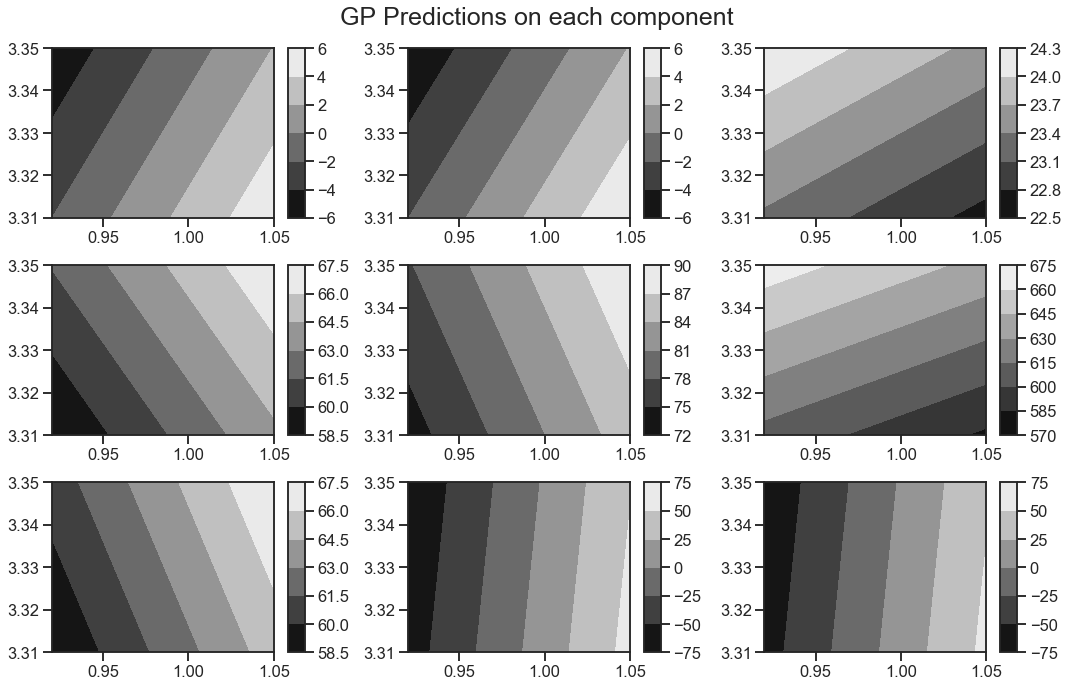

In [36]:
grid_size = 60

fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                gpmeans[ii].reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on each component', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [37]:
gplot, varplot = emu.predict_gps(eks, np.vstack([rs.flatten(), bs.flatten()]).T)

In [38]:
DGamma = Gamma - Gamma#- np.diag(np.diag(Gamma))

In [39]:
Hplot = ((gplot - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, gplot - y_obs[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)

for ii in tqdm(range(len(varplot.T))):
    Hplot_full[ii] = ((gplot[:,ii] - y_obs) * \
                      np.linalg.solve(2 * (DGamma + np.diag(varplot[:,ii])), gplot[:,ii] - y_obs)).sum() + \
                    0.5 * np.log(np.linalg.det(DGamma + np.diag(varplot[:,ii])))
    
Hplots = {}
Hplots['indp'] = [np.copy(Hplot), np.copy(Hplot_full)]

In [45]:
def plot_3axes(Phi, Hplot_rec, Hplot_full_rec, axes, **kwargs):
	k = kwargs.get('k', '')
	cmap = plt.get_cmap('gray');
	im = axes[0].contourf(np.exp(bs), np.exp(rs), np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)),
					  pltlevels, extend = 'min',
					  cmap = cmap_greys);

	axes[0].set_title(r'$\Phi_T(\theta; y)$'+'\n');
	axes[0].set_ylabel(k);
	axes[0].set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

	levels_m = np.log(find_levels(bs, rs, energy = Hplot_rec - logprior - logjac))
	im = axes[1].contourf(np.exp(bs), np.exp(rs), np.log((Hplot_rec - logprior - logjac).reshape(grid_size, grid_size)),
						  levels_m, extend = 'min',
					  cmap = cmap_greys);
	axes[1].set_title(r'$\Phi_{\mathsf{m}}(\theta; y)$'+'\n');
	axes[0].set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

	levels_gp = np.log(find_levels(bs, rs, energy = Hplot_full_rec - logprior -logjac - Hplot_full_rec.min()))
	im = axes[2].contourf(np.exp(bs), np.exp(rs), np.log((Hplot_full_rec - logprior -logjac - Hplot_full_rec.min()).reshape(grid_size, grid_size)),
						  levels_gp, extend = 'min',
					  cmap = cmap_greys);
	axes[2].set_title(r'$\Phi_{\mathsf{GP}}(\theta; y)$'+'\n');
	axes[0].set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

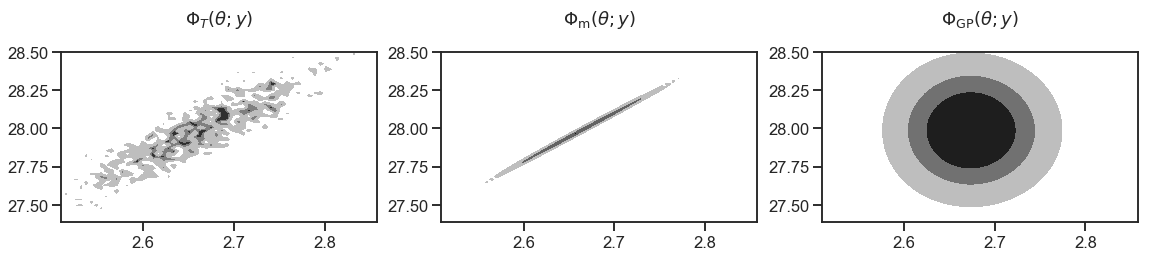

In [46]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot, Hplot_full, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
#     paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/'
#     file = 'l63_gp_independent'
#     plt.savefig(paper_directory+file+'.eps', dpi=150)

In [47]:
gpmodels = {}
gpmodels['indp'] = eks.gpmodels

<a id='time-var'></a>
# 2.3 Time variability diagonalization, wrt: $\Sigma$

From the long time data we can estimate the noise component of the shorter time-average model evaluations, which produces our observation covariance matrix $\Sigma$. We can diagonalize the matrix to obtain 

$$ \Sigma = Q \tilde \Sigma Q^\top, $$

where all matrices are of comforming sizes. That is, $Q\in \mathbb{R}^{p \times p}$ and $\tilde \Sigma \in \mathbb{R}^{p \times p }$, where $\tilde \Sigma$ is an invertible diagonal matrix and $Q$ is an orthogonal matrix.  

Using such diagonalization we can compute the misfit as follows: 

$$
\begin{align}
\|y - G(\theta) \|^2_{\Sigma} = \|\tilde y - \tilde G(\theta) \|^2_{\tilde \Sigma}, 
\end{align}
$$

where $\tilde y = Q^\top \, y $ and $\tilde G(\theta) = Q^\top \, G(\theta)$

[go back](#contents)

In [48]:
u,d,_ = np.linalg.svd(Gamma)

In [49]:
eks.Y = u.T.dot(eks.Gstar)

In [50]:
yhat = u.T.dot(y_obs)
Sigmahat = np.diag(d)

In [51]:
def emulate(eks):
    eks.gpmodels = []

    for ii, y in tqdm(enumerate(eks.Y[range(eks.n_obs)]), desc = 'GP training: ', total = eks.n_obs):
        with gp.defer_build():
            k = gp.kernels.Matern52(input_dim = eks.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            m  = gp.models.GPR(eks.Ustar.T, y[:,np.newaxis], k, m0)
#             m.kern.lengthscales.prior = gp.priors.Gamma(0.58310201, 0.08164469)
            m.kern.lengthscales.prior = gp.priors.Gamma(list(lenghtscale_params[0]), 
                                                        list(lenghtscale_params[1]))
            m.likelihood.variance = d[ii]

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        eks.gpmodels.append(m)

In [52]:
emulate(eks)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 584.062546
  Number of iterations: 55
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 584.062546
  Number of iterations: 55
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 398.868201
  Number of iterations: 61
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 398.868201
  Number of iterations: 61
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 269.424938
  Number of iterations: 41
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 269.424938
  Number of iterations: 41
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 223.814497
  Number of iterations: 79
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 223.814497
  Number of iterations: 79
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.389761
  Number of iterations: 78
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 99.389761
  Number of iterations: 78
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -33.605817
  Number of iterations: 75
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -33.605817
  Number of iterations: 75
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -110.486469
  Number of iterations: 92
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -110.486469
  Number of iterations: 92
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -177.087491
  Number of iterations: 140
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -177.087491
  Number of iterations: 140
  Number of functions evaluations: 176


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -278.932477
  Number of iterations: 73
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -278.932477
  Number of iterations: 73
  Number of functions evaluations: 97


In [53]:
# grid_size = 40
gpmeans, gpvars = emu.predict_gps(eks, np.vstack([rs.flatten(), bs.flatten()]).T)

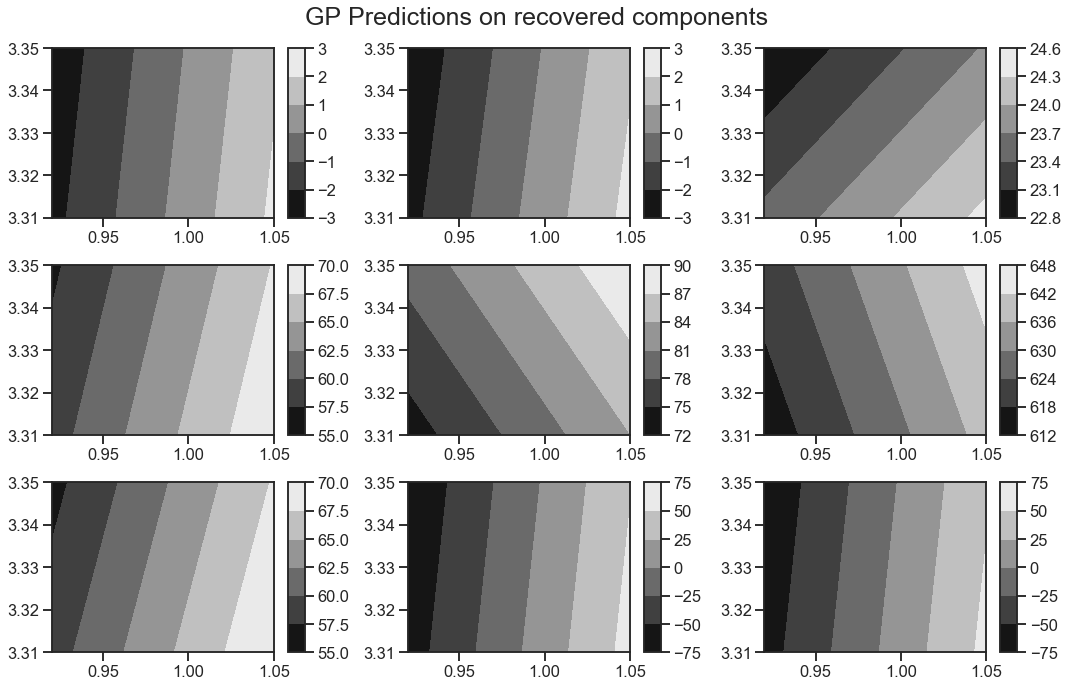

In [54]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                (u.dot(gpmeans)[ii]).reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on recovered components', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [55]:
gplot, varplot = emu.predict_gps(eks, np.vstack([rs.flatten(), bs.flatten()]).T)

In [56]:
Hplot = ((gplot - u.T.dot(y_obs)[:,np.newaxis]) * \
         np.linalg.solve(2 * np.diag(d), gplot - u.T.dot(y_obs)[:,np.newaxis])).sum(axis = 0)
Hplot_full = np.empty(shape = Hplot.shape)

for ii in tqdm(range(len(varplot.T))):
    Hplot_full[ii] = ((gplot[:,ii] - u.T.dot(y_obs)) * \
                      np.linalg.solve(2 * ( 0.0 * np.diag(d) + np.diag(varplot[:,ii])), 
                                      gplot[:,ii] - u.T.dot(y_obs))).sum() + \
                    0.5 * np.log(0.0 * d + varplot[:,ii]).sum()

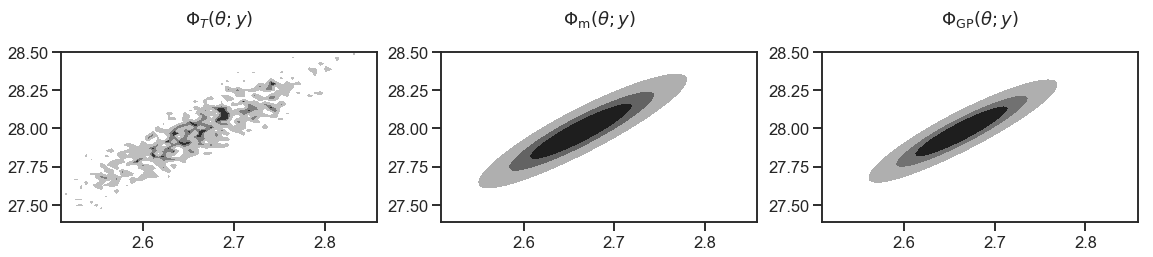

In [57]:
# The problem arises with levels_m <- take a look! 

fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot, Hplot_full, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
#     paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/'
#     file = 'l63_gp_timediag_zoom'
#     plt.savefig(paper_directory+file+'.eps', dpi=150)

In [58]:
gpmodels['time-diag'] = eks.gpmodels
Hplots['time-diag'] = [np.copy(Hplot), np.copy(Hplot_full)]

<a id='par-var'></a>
# 2.4  Parameter variability

The EKS samples generate a set of training runs for the GP that can be stored in matrix form $G\in \mathbb{R}^{J\times p}$. Diagonalizing this matrix would account for parameter variability. Thus, we can compute an incomplete SVD decomposition of the form 

$$ G = \hat G D V^\top, $$

where all matrices are of comforming sizes. That is, $\hat G\in \mathbb{R}^{J \times p}$ and $D,V \in \mathbb{R}^{p \times p}$, where $D$ is an invertible diagonal matrix and $V$ is an orthogonal matrix.  

Note that every row in this matrix accounts for $G(\theta_j)^\top$ where $j = 1, \ldots, J$. So we can compute the misfit as follows: 

$$
\begin{align}
\|y - G(\theta) \|^2_{\Sigma} = \|\hat y - \hat G(\theta) \|^2_{\hat \Sigma}, 
\end{align}
$$

where $\hat y = D^{-1}V^\top \, y $, $\hat G(\theta) = D^{-1}V^\top \, G(\theta)$, and $\hat \Sigma = D^{-1}V^\top\Sigma V D^{-1}$

[go back](#contents)

In [59]:
mG     = eks.Gstar.mean(axis = 1).reshape(-1,1)
u,d,vh = np.linalg.svd((eks.Gstar - mG).T, full_matrices=False)
eks.Y = u.T
v = vh.T

In [60]:
VDh = np.diag(1./d).dot(vh)
S = np.matmul(VDh, np.matmul(Gamma, VDh.T))

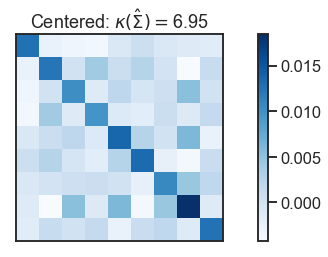

In [61]:
fig, axes = plt.subplots(1,1,figsize = (10,4))

im = axes.imshow(S, cmap = 'Blues');
plt.colorbar(im, ax= axes);
axes.set_yticks([])
axes.set_xticks([])
axes.set_title(r'Centered: $\kappa(\hat \Sigma) = $%s'%round(np.linalg.cond(S), 2))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [62]:
def emulate(eks):
    eks.gpmodels = []

    for ii, y in tqdm(enumerate(eks.Y[range(eks.n_obs)]), desc = 'GP training: ', total = eks.n_obs):
        with gp.defer_build():
            k  = gp.kernels.Matern52(input_dim = eks.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            m  = gp.models.GPR(eks.Ustar.T, y[:,np.newaxis], k, m0)
#             m.kern.lengthscales.prior = gp.priors.Gamma(0.58310201, 0.08164469)
            m.kern.lengthscales.prior = gp.priors.Gamma(list(lenghtscale_params[0]), 
                                                        list(lenghtscale_params[1]))
            m.likelihood.variance = 1./eks.J

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        eks.gpmodels.append(m)

In [63]:
emulate(eks)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -90.802724
  Number of iterations: 67
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -90.802724
  Number of iterations: 67
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -95.562418
  Number of iterations: 56
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -95.562418
  Number of iterations: 56
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -90.019181
  Number of iterations: 90
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -90.019181
  Number of iterations: 90
  Number of functions evaluations: 103


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -111.762510
  Number of iterations: 108
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -111.762510
  Number of iterations: 108
  Number of functions evaluations: 130


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -98.190205
  Number of iterations: 77
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -98.190205
  Number of iterations: 77
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -95.650959
  Number of iterations: 61
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -95.650959
  Number of iterations: 61
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -88.440034
  Number of iterations: 67
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -88.440034
  Number of iterations: 67
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -107.020566
  Number of iterations: 149
  Number of functions evaluations: 174


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -107.020566
  Number of iterations: 149
  Number of functions evaluations: 174


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88.862029
  Number of iterations: 80
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -88.862029
  Number of iterations: 80
  Number of functions evaluations: 107


In [64]:
gpmeans, gpvars = emu.predict_gps(eks, np.vstack([rs.flatten(), bs.flatten()]).T)

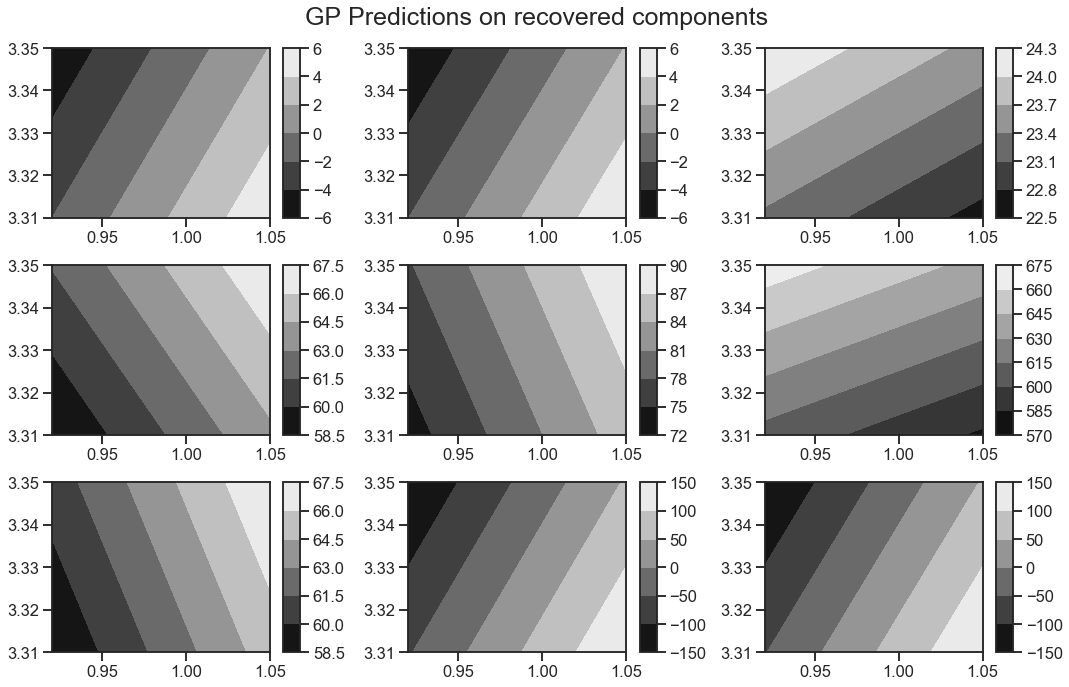

In [65]:
fig, axes = plt.subplots(3,3,figsize=(15, 10))
cmap = plt.get_cmap('gray')

gpmeans_ = (np.matmul(vh.T, np.matmul(np.diag(d), gpmeans)) + mG)

for ii, ax in enumerate(axes.flatten()):
    im = ax.contourf(bs, rs,
                (gpmeans_[ii]).reshape(grid_size, grid_size), 5, cmap = cmap)
    plt.colorbar(im, cmap = cmap, ax= ax, aspect = 10)
    
plt.suptitle('GP Predictions on recovered components', fontsize = 25);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [66]:
VDh = np.diag(1/d).dot(vh)

In [67]:
gplot, varplot = emu.predict_gps(eks, np.vstack([rs.flatten(), bs.flatten()]).T)

In [68]:
VD = v.dot(np.diag(d))
mG = eks.Gstar.mean(axis = 1).reshape(-1,1)
yG = VD.dot(gplot) + mG - y_obs.reshape(-1,1)

Hplot_rec = (yG * np.linalg.solve(2 * Gamma, yG)).sum(axis = 0)
Hplot_full_rec = np.empty(shape = Hplot_rec.shape)

for ii in tqdm(range(len(varplot.T)), desc = 'Grid points: '):
    Hplot_full_rec[ii] = ((yG[:,ii]) * np.linalg.solve(2 * VD.dot(np.diag(varplot[:,ii])).dot(VD.T), 
                                                       yG[:,ii])).sum() + \
                    0.5 * np.log(np.linalg.det(VD.dot(np.diag(varplot[:,ii])).dot(VD.T)))

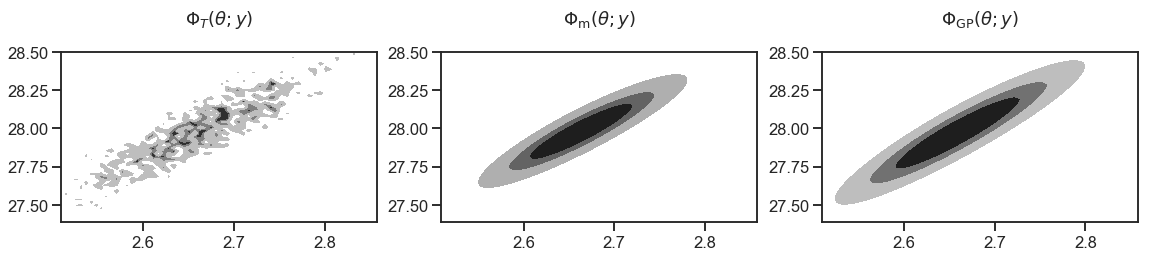

In [69]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot_rec, Hplot_full_rec, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
#     paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/'
#     file = 'l63_gp_pcadiag_zoom'
#     plt.savefig(paper_directory+file+'.eps', dpi=150)

In [70]:
ytilde = VDh.dot((y_obs.reshape(-1,1) - mG))
Sigmatilde = VDh.dot(Gamma).dot(VDh.T)
gpmodels['pca-diag'] = eks.gpmodels
Hplots['pca-diag'] = [np.copy(Hplot_rec), np.copy(Hplot_full_rec)]

In [71]:
mG = eks.Gstar.mean(axis = 1).reshape(-1,1)
yG = gplot - ytilde

Hplot_rec = (yG * np.linalg.solve(2 * Sigmatilde, yG)).sum(axis = 0)
Hplot_full_rec = np.empty(shape = Hplot_rec.shape)

for ii in tqdm(range(len(varplot.T)), desc = 'Grid points: '):
    Hplot_full_rec[ii] = ((yG[:,ii]) * np.linalg.solve(2 * np.diag(varplot[:,ii]), yG[:,ii])).sum() + \
                    0.5 * np.log(np.linalg.det(np.diag(varplot[:,ii])))

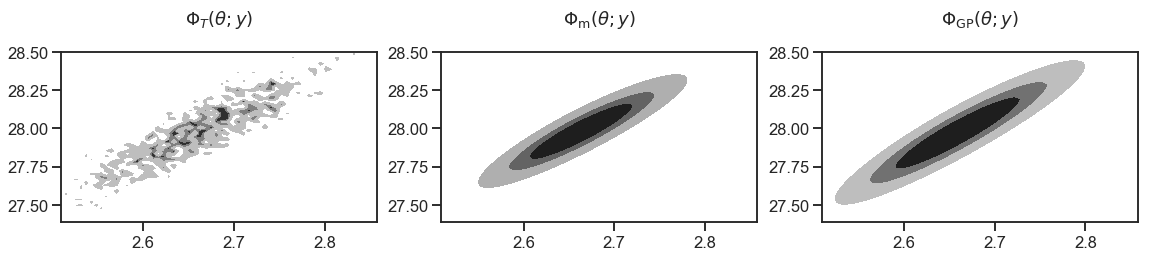

In [72]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
plot_3axes(Phi, Hplot_rec, Hplot_full_rec, axes)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<a id='sample'></a>
# Sample

Use random walk metropolis with the GP emulators.

[go back](#contents)

In [73]:
eks.gpmodels = gpmodels['indp']

In [74]:
prior = multivariate_normal(mean = eks.mu.flatten(), cov = eks.sigma)

In [75]:
n_mcmc = 5000
mcmcs = {}
mcmc = MCMC()
mcmc.y_obs = y_obs
mcmc.gp_mh(eks, n_mcmc, prior, model = model)
mcmcs['indp'] = [mcmc]

In [76]:
mcmc = MCMC()
mcmc.y_obs = y_obs
mcmc.gp_mh(eks, n_mcmc, prior, Gamma = Gamma, model = model)
mcmcs['indp'].append(mcmc)

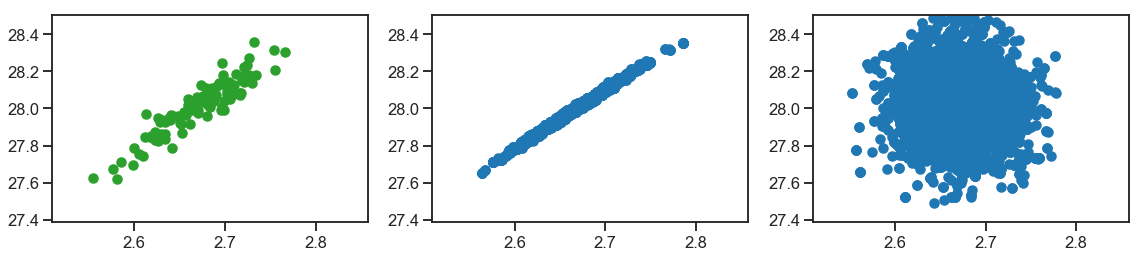

In [77]:
emu_type = 'indp'

fig, axes = plt.subplots(1,3, figsize = (16, 4))
axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]))
axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]))
axes[0].scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c')
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [78]:
eks.gpmodels = gpmodels['time-diag']

mcmc = MCMC()
mcmc.y_obs = yhat
mcmc.gp_mh(eks, n_mcmc, prior, model = model)
mcmcs['time-diag'] = [mcmc]

In [79]:
mcmc = MCMC()
mcmc.y_obs = yhat
mcmc.gp_mh(eks, n_mcmc, prior, Gamma = Sigmahat, model = model)
mcmcs['time-diag'].append(mcmc)

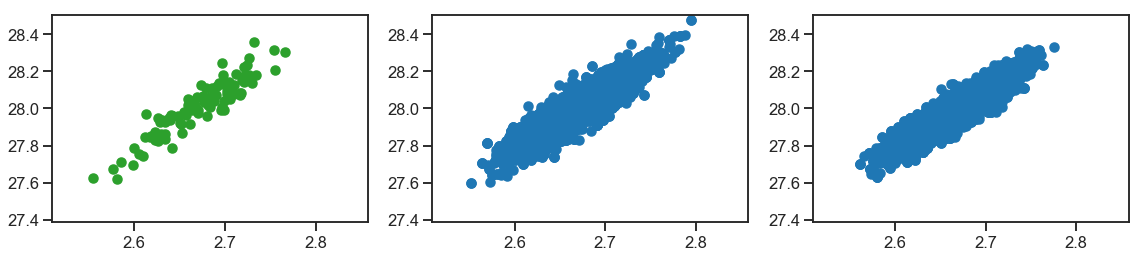

In [80]:
emu_type = 'time-diag'

fig, axes = plt.subplots(1,3, figsize = (16, 4))
# plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes) 
axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]))
axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]))
axes[0].scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c')
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [81]:
emu_type = 'pca-diag'

eks.gpmodels = gpmodels[emu_type]

mcmc = MCMC()
mcmc.y_obs = ytilde
mcmc.gp_mh(eks, n_mcmc, prior, model = model)
mcmcs[emu_type] = [mcmc]

In [82]:
mcmc = MCMC()
mcmc.y_obs = ytilde
mcmc.gp_mh(eks, n_mcmc, prior, Gamma = Sigmatilde, model = model)
mcmcs[emu_type].append(mcmc)

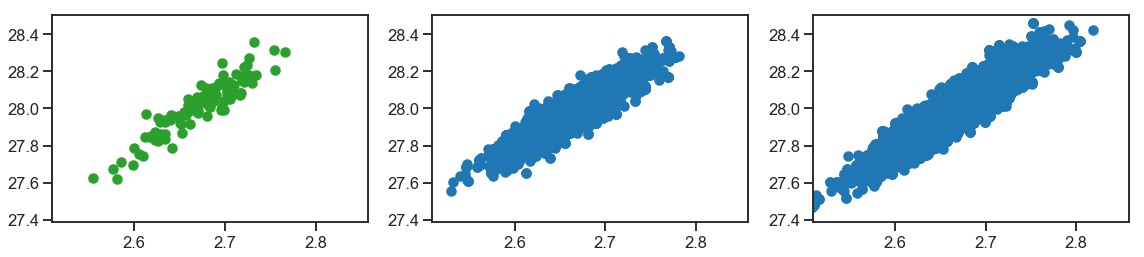

In [83]:
fig, axes = plt.subplots(1,3, figsize = (16, 4))
# plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes) 
axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]))
axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]))
axes[0].scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c')
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

[go back](#contents)

In [84]:
mcmc = MCMC()
mcmc.y_obs = y_obs
model.t = t_eks
model.wt= wt
mcmc.model_mh(model, n_mcmc, prior, eks, Gamma)

In [85]:
mcmcs['model'] = [mcmc]

In [86]:
list(mcmcs.keys())[:-1]

['indp', 'time-diag', 'pca-diag']

In [89]:
def scatter_samples(eks, mcmcs, emu_type, axes):
	axes[0].scatter(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', marker = '+', s = 30, linewidth = 1)
	axes[1].scatter(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', marker = '+', s = 30, linewidth = 1)
	axes[2].scatter(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]), color = u'#ff7f0e', marker = '+', s = 30, linewidth = 1)
	axes[2].scatter(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]),  marker = '+', s = 30, linewidth = 1,)
	axes[1].scatter(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]),  marker = '+', s = 30, linewidth = 1,)
	axes[0].scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c',  marker = '+', s = 30, linewidth = 2)


Text(68.25, 0.5, 'Parameter\n uncorrelated ')

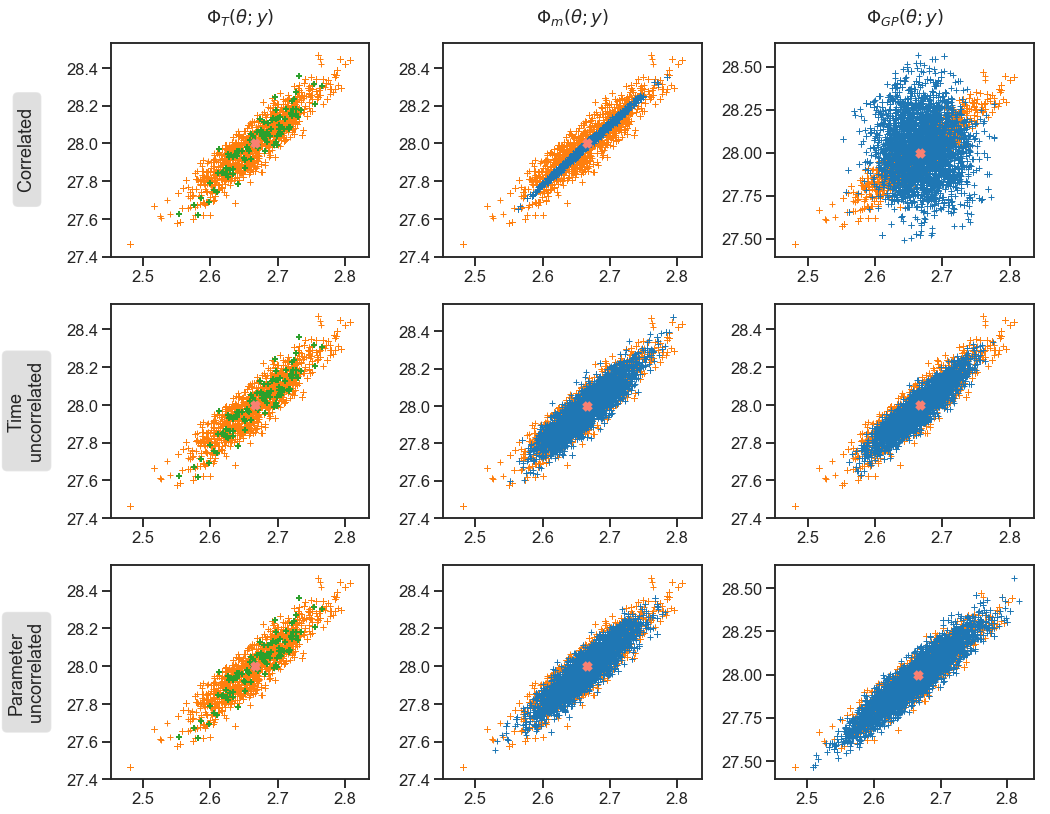

In [111]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (14,12))

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    scatter_samples(eks, mcmcs, emu_type, axes[kk].flatten())

for ax in axes.flatten():
    ax.set_ylabel('')
    ax.scatter(np.exp(eks.ustar[1]), np.exp(eks.ustar[0]), marker = 'x', s = 50, linewidth = 5, color = 'salmon')
    ax.set_title('')    

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axes[0, 0].set_title(r"$\Phi_T(\theta;y)$", pad=20)
axes[0, 1].set_title(r"$\Phi_{m}(\theta;y)$", pad=20)    
axes[0, 2].set_title(r"$\Phi_{GP}(\theta;y)$", pad=20)  

axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  


# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-mcmc-alt'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [91]:
grid_size = 60

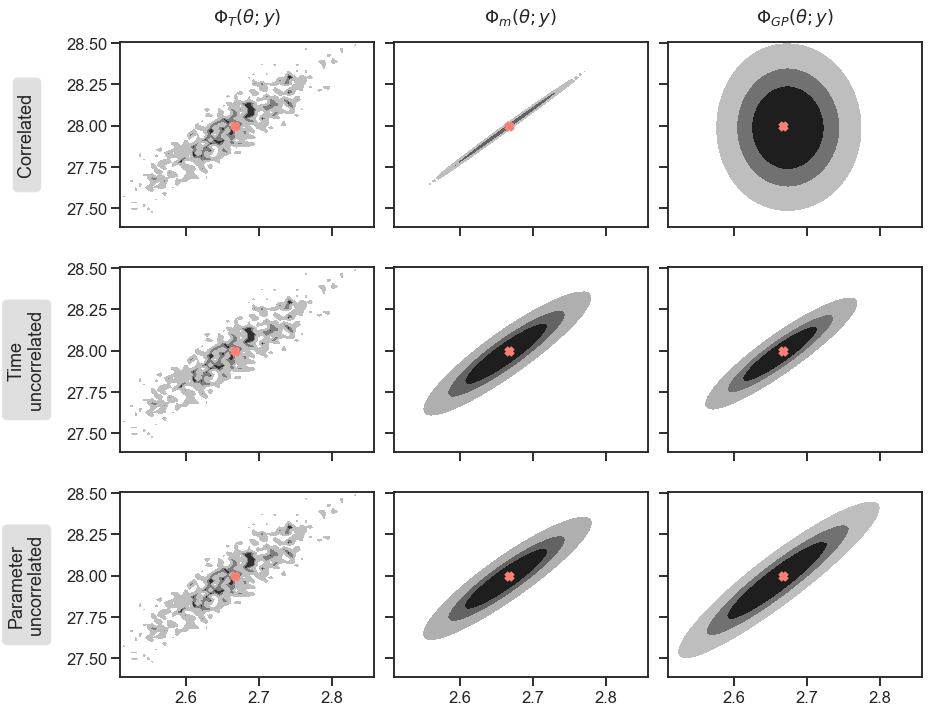

In [92]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]), 3, 
                         figsize = (13,10), sharex = True, sharey = True)

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes[kk].flatten(), k = 'Type: %s'%(emu_type)) 
    
for ax in axes.flatten():
    ax.set_ylabel('')
    ax.scatter(np.exp(eks.ustar[1]), np.exp(eks.ustar[0]), marker = 'x', s = 50, linewidth = 5, color = 'salmon')
    ax.set_title('')
    
axes[0, 0].set_title(r"$\Phi_T(\theta;y)$", pad=20)
axes[0, 1].set_title(r"$\Phi_{m}(\theta;y)$", pad=20)    
axes[0, 2].set_title(r"$\Phi_{GP}(\theta;y)$", pad=20)  

axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  
    
# plt.subplots_adjust(hspace = 0.25)
fig.tight_layout(h_pad = 2.2, w_pad = .2)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.5)

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-contours-labels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [93]:
blues = ['#75b8e7', '#439fdf', '#258dd5', '#1f77b4', '#134b71'] 

In [94]:
mcmcs

{'indp': [<ces.sample.MCMC at 0x7f86ec1c93c8>,
 'time-diag': [<ces.sample.MCMC at 0x7f86ecfdff60>,
 'pca-diag': [<ces.sample.MCMC at 0x7f86ec1c6e10>,
 'model': [<ces.sample.MCMC at 0x7f86e9772a20>]}

In [96]:
def kde_samples(eks, mcmcs, emu_type, axes, shade_lowest = False, n_levels = 4, alpha = 1.):
	plot_kde(np.exp(mcmcs[emu_type][0].samples[1]), np.exp(mcmcs[emu_type][0].samples[0]),
			 axes[2], cmap = cmap_blues, alpha = alpha)
	plot_kde(np.exp(mcmcs[emu_type][1].samples[1]), np.exp(mcmcs[emu_type][1].samples[0]),
			 axes[1], cmap = cmap_blues, alpha = alpha)
	plot_kde(np.exp(mcmc.samples[1]), np.exp(mcmc.samples[0]),
				axes[0], cmap = cmap_oranges, alpha = alpha)
	axes[0].scatter(np.exp(eks.Ustar[1]), np.exp(eks.Ustar[0]), color =  u'#2ca02c',  marker = '+', s = 30, linewidth = 2)

	axes[0].set_title(r'$\Phi_T(\theta; y)$'+'\n');
	axes[1].set_title(r'$\Phi_{\mathsf{m}}(\theta; y)$'+'\n');
	axes[2].set_title(r'$\Phi_{\mathsf{GP}}(\theta; y)$'+'\n');


/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'normed'
  s)


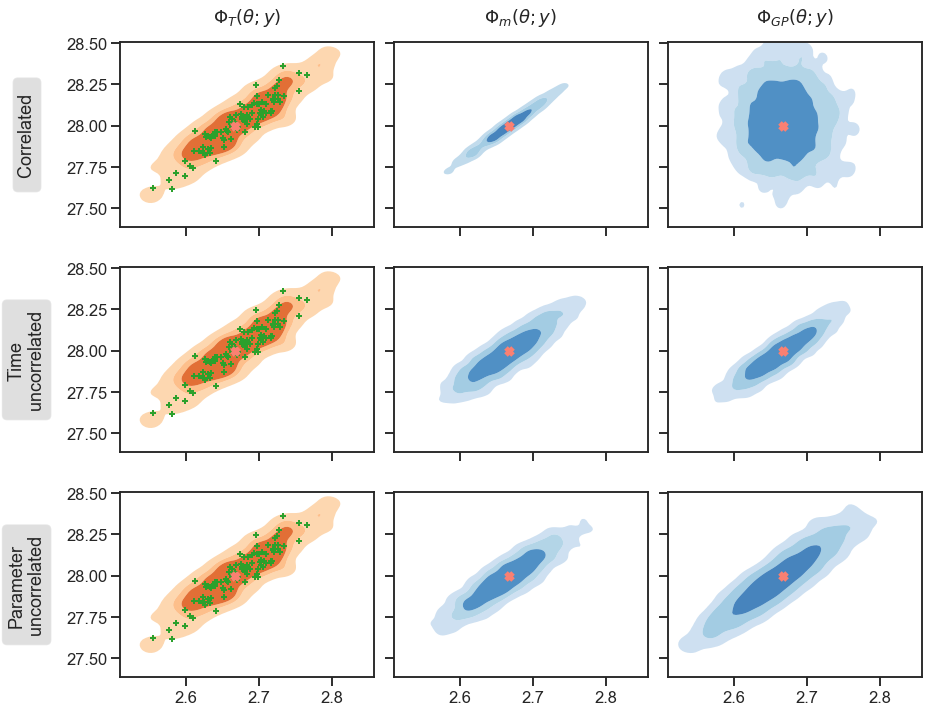

In [97]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (13,10), sharex = True, sharey = True)

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    kde_samples(eks, mcmcs, emu_type, axes[kk].flatten(), alpha = .8)
    
for ax in axes.flatten():
    ax.set(xlim=(np.exp(logb_lo), np.exp(logb_up)), ylim=(np.exp(logr_lo), np.exp(logr_up)))
    ax.set_ylabel('')
    ax.scatter(np.exp(eks.ustar[1]), np.exp(eks.ustar[0]), marker = 'x', s = 50, linewidth = 5, color = 'salmon')
    ax.set_title('')
    
axes[0, 0].set_title(r"$\Phi_T(\theta;y)$", pad=20)
axes[0, 1].set_title(r"$\Phi_{m}(\theta;y)$", pad=20)    
axes[0, 2].set_title(r"$\Phi_{GP}(\theta;y)$", pad=20) 

axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  

fig.tight_layout(h_pad = 2.2, w_pad = .2)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# if save_figs : 
# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-mcmc-kde-alt-labels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

In [98]:
for key in list(mcmcs.keys())[:-1]:
    tqdm.write('(%s, %s)'%(mcmcs[key][0].accept,mcmcs[key][1].accept))

(0.5578, 0.1402)
(0.4726, 0.5094)
(0.5862, 0.5052)


In [99]:
accepts = np.array([(mcmcs[key][0].accept, mcmcs[key][1].accept) for key in list(mcmcs.keys())[:-1]])

In [100]:
mcmc.accept

0.1934

[go back](#contents)

In [101]:
clevels = np.round(st.chi2(df = eks.p).ppf(q = [.68, .90, .99]), 6)
clevels

array([2.278869, 4.60517 , 9.21034 ])

In [102]:
probs = {2.278869: r'$68\%$', 
         4.60517: r'$90\%$', 
         9.21034: r'$99\%$'}

In [103]:
def ellipse(mcmcs, emu_type, ix):
    mu = mcmcs[emu_type][ix].samples.mean(axis = 1)
    Sigma = np.cov(mcmcs[emu_type][ix].samples)
    xs_ = np.vstack([rs.flatten(), bs.flatten()])
    xs_mu = xs_ - mu.reshape(-1,1)
    dist = (xs_mu * np.linalg.solve(Sigma, xs_mu)).sum(axis = 0)
    return dist

In [104]:
def draw_ellipse(mcmcs, emu_type, axes, color = '#d62728'):
    im = axes[0].contour(np.exp(bs), np.exp(rs), 
                         ellipse(mcmcs, 'model', 0).reshape(grid_size, grid_size), clevels, 
                         colors = color,
                         extend="both");
    axes[0].clabel(im,  fmt = probs,  inline=1, fontsize=12);

    im = axes[1].contour(np.exp(bs), np.exp(rs), 
                         ellipse(mcmcs, emu_type, 1).reshape(grid_size, grid_size), clevels, 
                         colors = color,
                         extend="both");
    axes[1].clabel(im,  fmt = probs,  inline=1, fontsize=12);


    im = axes[2].contour(np.exp(bs), np.exp(rs), 
                         ellipse(mcmcs, emu_type, 0).reshape(grid_size, grid_size), clevels, 
                         colors = color,
                         extend="both");
    axes[2].clabel(im,  fmt = probs,  inline=1, fontsize=12);
    

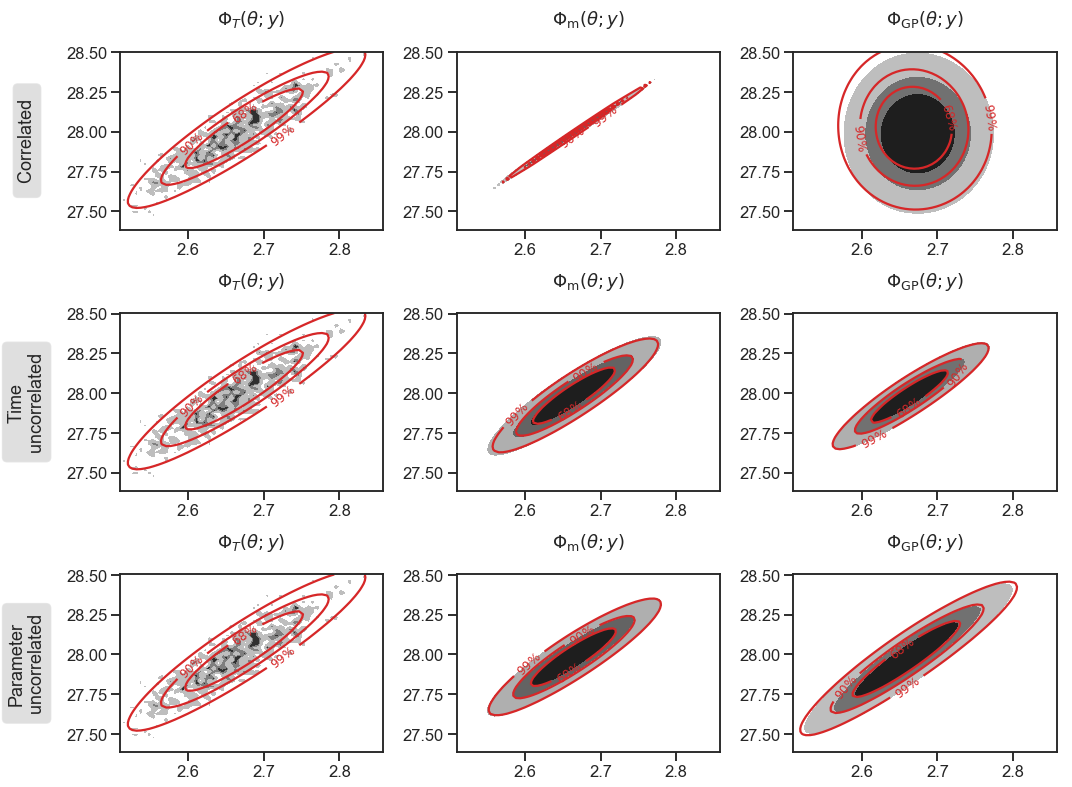

In [105]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (15,12))

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    plot_3axes(Phi, Hplots[emu_type][0], Hplots[emu_type][1], axes[kk].flatten(), k = 'Type: %s'%(emu_type))
    draw_ellipse(mcmcs, emu_type, axes[kk].flatten())
    
axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  

    
#     scatter_samples(eks, mcmcs, emu_type, axes[kk].flatten())

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-contours-plevels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'normed'
  s)


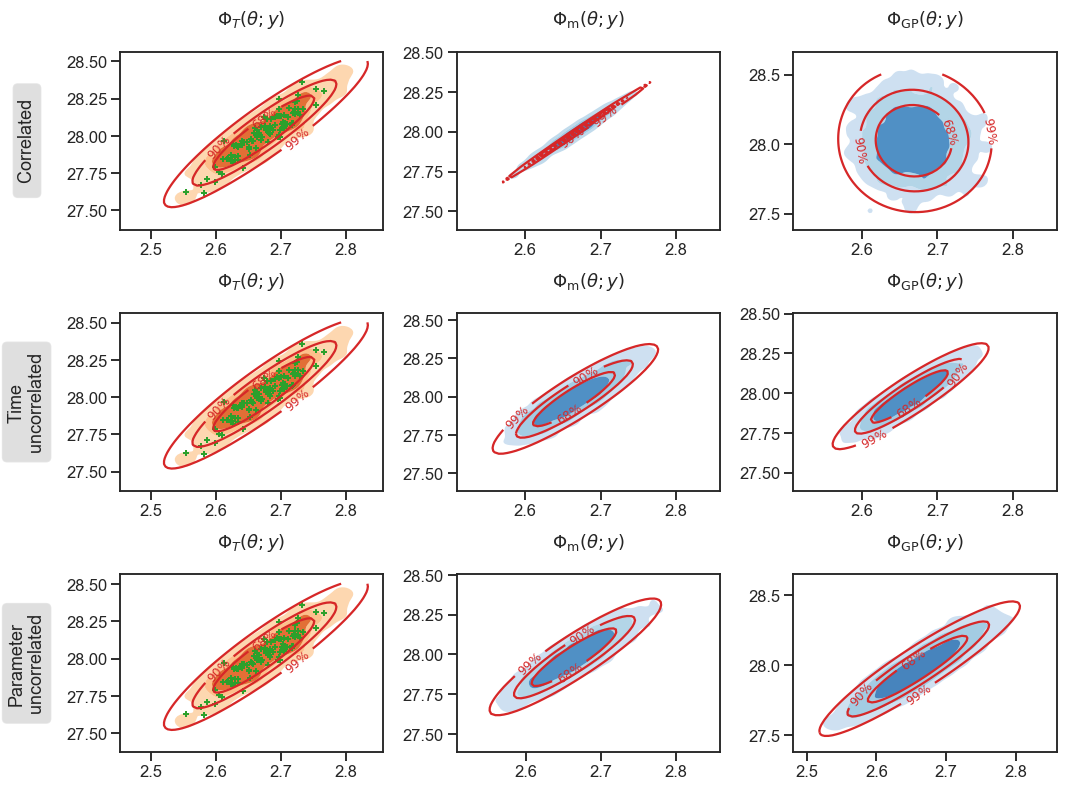

In [106]:
fig, axes = plt.subplots(len(list(mcmcs.keys())[:-1]),3, figsize = (15,12))

for kk, emu_type in enumerate(list(mcmcs.keys())[:-1]):
    kde_samples(eks, mcmcs, emu_type, axes[kk].flatten(), alpha = .8)
    draw_ellipse(mcmcs, emu_type, axes[kk].flatten())
#     scatter_samples(eks, mcmcs, emu_type, axes[kk].flatten())

axes[0, 0].set_ylabel("  Correlated  ",labelpad=30, bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))
axes[1, 0].set_ylabel("Time\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))    
axes[2, 0].set_ylabel("Parameter\n uncorrelated ", labelpad=20,bbox=dict(facecolor='gray', alpha=0.25,boxstyle="round"))  

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# paper_directory = '/Users/agarbuno/github-repos/ces-draft/img/lorenz63/'
# file = 'l63-gp-mcmc-kde-plevels'
# plt.savefig(paper_directory+file+'.png', dpi=150)

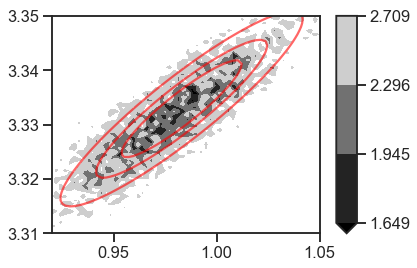

In [107]:
im = plt.contourf(bs, rs,  np.log((Phi - logprior - logjac).reshape(grid_size, grid_size)), 
             np.exp(np.linspace(0.5, .996471074, 4)), extend = 'min',
             cmap = cmap)
plt.colorbar(im, cmap = cmap, aspect = 10)
im = plt.contour(bs, rs, ellipse(mcmcs, 'model', 0).reshape(grid_size, grid_size), clevels, 
                         colors = "red", alpha = .6, extend = "both");
# plt.clabel(im,  fmt = probs,  inline=1, fontsize=12);

In [108]:
np.log(np.linspace(1.4, 2.4, 5))

array([0.33647224, 0.50077529, 0.64185389, 0.76546784, 0.87546874])

In [109]:
np.exp(np.linspace(-0.22314355, 1.06471074, 4))

array([0.8       , 1.22892673, 1.88782614, 2.90000001])